In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import time
import torch.utils.data
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
import torch.optim as optim
from models import *
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR, ExponentialLR, StepLR, CosineAnnealingLR


c:\Users\Citylab\.conda\envs\torchenv2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def load_and_prepare_data():
    
    data_batches, label_batches = [], []
    for i in range(1, 6):
        batch = unpickle(f'data/KaggleData/cifar-10-python/cifar-10-batches-py/data_batch_{i}')
        data_batches.append(batch[b'data'])
        label_batches.append(batch[b'labels'])
    X, y = np.concatenate(data_batches), np.concatenate(label_batches)
    
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = load_and_prepare_data()


stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transformations = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(), 
        transforms.RandomApply([transforms.RandomErasing()], p=0.5),
        transforms.Normalize(*stats)]),
        
    'valid': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)]),
        
    
    'normalization_only': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(*stats)])
}


class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None, data_mode='default'):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.data_mode = data_mode
        if data_mode == 'train_Enhanced':
            self.data = np.concatenate((self.data, self.data), axis=0)
            self.labels = np.concatenate((self.labels, self.labels), axis=0)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.data_mode == 'train_Enhanced' and idx >= len(self.labels) // 2:
            transform = transformations['train']
        else:
            transform = self.transform
        image = self.data[idx % len(self.labels)].reshape(3, 32, 32).transpose(1, 2, 0)
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        image = transform(image)
        return image, self.labels[idx % len(self.labels)]


datasets = {
    'train_Enhanced': CIFAR10Dataset(X_train, y_train, transform=transformations['normalization_only'], data_mode='train_Enhanced'),
    'valid': CIFAR10Dataset(X_val, y_val, transform=transformations['valid'])
}


loaders = {
    'train_Enhanced': DataLoader(datasets['train_Enhanced'], batch_size=64, shuffle=True),
    'valid': DataLoader(datasets['valid'], batch_size=64, shuffle=False)
}

print('Amount of Train Data batches (Enhanced):', len(loaders['train_Enhanced']))
print('Amount of Valid Data batches:', len(loaders['valid']))

print('Amount of training images (Enhanced):', len(datasets['train_Enhanced']))
print('Amount of Validation images:', len(X_val))


Amount of Train Data batches (Enhanced): 1250
Amount of Valid Data batches: 157
Amount of training images (Enhanced): 80000
Amount of Validation images: 10000


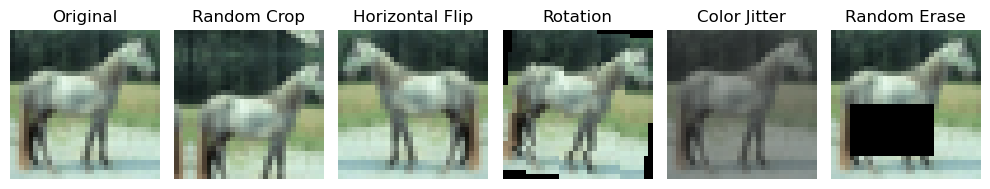

In [23]:
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from PIL import Image


index = np.random.randint(0, len(X_train))  
example_image_array = X_train[index]
example_image = Image.fromarray(example_image_array.reshape(3, 32, 32).transpose(1, 2, 0))


transformations_list = [
    ('Original', None),
    ('Random Crop', transforms.RandomCrop(32, padding=8, padding_mode='reflect')),  
    ('Horizontal Flip', transforms.RandomHorizontalFlip(p=1)),  
    ('Rotation', transforms.RandomRotation(degrees=15)),  
    ('Color Jitter', transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5)),  
    ('Random Erase', transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(0.02, 0.25))  
    ])),
]

fig, axes = plt.subplots(1, len(transformations_list), figsize=(10, 3))
for ax, (trans_name, transform) in zip(axes, transformations_list):
    if transform is not None:
        if trans_name == 'Random Erase': 
            transformed_image = transform(example_image.convert('RGB'))
        elif trans_name == 'Normalize':  
            transformed_image = transforms.ToTensor()(example_image)
            transformed_image = transform(transformed_image)
        else:  
            transformed_image = transform(example_image)
    else:
        transformed_image = example_image  

    
    if isinstance(transformed_image, torch.Tensor):
        transformed_image = transformed_image.permute(1, 2, 0).numpy()
        
        if trans_name == 'Normalize':
            mean = np.array(stats[0])
            std = np.array(stats[1])
            transformed_image = transformed_image * std + mean
            transformed_image = np.clip(transformed_image, 0, 1)
    else:
        transformed_image = np.array(transformed_image)

    ax.imshow(transformed_image)
    ax.set_title(trans_name)
    ax.axis('off')
plt.tight_layout()
plt.show()
